In [122]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from cv2 import imshow
from math import atan2, degrees, fabs
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML, display
import json




def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
    """Returns high confidence keypoints and edges for visualization.

    Args:
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
        height: height of the image in pixels.
        width: width of the image in pixels.
        keypoint_threshold: minimum confidence score for a keypoint to be
        visualized.

    Returns:
        A (keypoints_xy, edges_xy, edge_colors) containing:
        * the coordinates of all keypoints of all detected entities;
        * the coordinates of all skeleton edges of all detected entities;
        * the colors in which the edges should be plotted.
    """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
            [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
        kpts_above_thresh_absolute = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (kpts_scores[edge_pair[0]] > keypoint_threshold and
            kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors

def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
    """Draws the keypoint predictions on image.

    Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

    Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
    """
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges,
    edge_colors) = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize=(output_image_width, output_image_height),
            interpolation=cv2.INTER_CUBIC)
    return image_from_plot

def plot_on_image(image, keypoints_with_scores):

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    plt.figure(figsize=(5, 5))
    plt.imshow(output_overlay)
    _ = plt.axis('off')

def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle >180.0:
        angle = 360-angle

    return angle




In [123]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'g',
    (0, 2): 'g',
    (1, 3): 'g',
    (2, 4): 'g',
    (0, 5): 'g',
    (0, 6): 'g',
    (5, 7): 'g',
    (7, 9): 'g',
    (6, 8): 'g',
    (8, 10): 'g',
    (5, 6): 'g',
    (5, 11): 'g',
    (6, 12): 'g',
    (11, 12): 'g',
    (11, 13): 'g',
    (13, 15): 'g',
    (12, 14): 'g',
    (14, 16): 'g',
}

Downward_Facing_Dog_pose_or_Adho_Mukha_Svanasana_m = {
    "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 0,
    "left_shoulder_a": 0,
    "right_shoulder_b": 0,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 0,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 0,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Tree_Pose_or_Vrksasana_m = {
    "left_elbow_a": 0,
    "right_elbow_a": 0,
    "left_shoulder_b": 0,
    "left_shoulder_a": 0,
    "right_shoulder_b": 0,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 0,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 0,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Warrior_I_Pose_or_Virabhadrasana_I_m = {
    "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 1,
    "left_shoulder_a": 0,
    "right_shoulder_b": 1,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 0,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 0,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Warrior_II_Pose_or_Virabhadrasana_II_m = {
    "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 1,
    "left_shoulder_a": 0,
    "right_shoulder_b": 1,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 1,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 1,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Warrior_III_Pose_or_Virabhadrasana_III_m = {
    "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 1,
    "left_shoulder_a": 0,
    "right_shoulder_b": 1,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 1,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 1,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

In [124]:
root_dir = '../images'
image_path = root_dir + '/' + 'test2.jpg'
image = np.array(Image.open(image_path))

prediction = 'Downward_Facing_Dog_pose_or_Adho_Mukha_Svanasana_'

In [125]:
image.shape

(447, 640, 3)

In [126]:
#def pose_detection_model(image, prediction):

#decode_image = tf.image.decode_jpeg(image)
input_image = tf.expand_dims(image, axis=0)
input_size = 192
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    
def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    
    return keypoints_with_scores

keypoints_with_scores = movenet(input_image)

    

In [127]:
keypoints_with_scores.shape

(1, 1, 17, 3)

In [128]:
def angle_calc(keypoints_with_scores):  #(image_capture)
    # input_size = 192
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    # input_image = tf.expand_dims(image, axis=0)
    # input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    # keypoints_with_scores = movenet(input_image)

    # # Visualize the predictions with image.
    # display_image = tf.expand_dims(image, axis=0)
    # display_image = tf.cast(tf.image.resize_with_pad(
    #     display_image, 1280, 1280), dtype=tf.int32)
    # output_overlay = draw_prediction_on_image(
    #     np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    key_xy = keypoints_with_scores[:, :, :, :2]

    # Create a dictionary of keypoints and their corresponding vector tuples
    key_dict = {}
    for key, value in KEYPOINT_DICT.items():
        vector = tuple(key_xy[0, 0, value])
        key_dict[key] = vector


    # make angles_dictionary
    angles_dictionary = {
    "left_elbow_a": (key_dict["left_wrist"],key_dict["left_elbow"],key_dict["left_shoulder"]),
    "right_elbow_a": (key_dict["right_wrist"],key_dict["right_elbow"],key_dict["right_shoulder"]),
    "left_shoulder_b": (key_dict["left_elbow"],key_dict["left_shoulder"],key_dict["left_hip"]),
    "left_shoulder_a": (key_dict["left_hip"],key_dict["left_shoulder"],key_dict["right_shoulder"]),
    "right_shoulder_b": (key_dict["right_elbow"],key_dict["right_shoulder"],key_dict[ "right_hip"]),
    "right_shoulder_a": (key_dict["right_hip"],key_dict["right_shoulder"],key_dict[ "left_shoulder"]),
    "left_hip_a": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "right_hip"]),
    "left_hip_b": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "left_hip_c": (key_dict["right_hip"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "right_hip_a": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "left_hip"]),
    "right_hip_b": (key_dict["left_hip"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "right_hip_c": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "left_knee_a": (key_dict["left_hip"],key_dict["left_knee"],key_dict[ "left_ankle"]),
    "right_knee_a": (key_dict["right_hip"],key_dict["right_knee"],key_dict[ "right_ankle"])
    }

    angles = {}

    for key, value in angles_dictionary.items():
        angle = calculate_angle(value[0], value[1], value[2])
        angles[key] = angle

    return(angles)



angles = angle_calc(keypoints_with_scores)
    

In [129]:
#get angles comparrison
def compare_angles(prediction, angles):

    # Opening JSON file
    with open('data.json') as json_file:
        data = json.load(json_file)

        # Print the type of data variable
        #print("Type:", type(data))

        # Print the data of dictionary
        ground_pose_dict = data

    dict1 = ground_pose_dict[prediction]
    dict2 = angles
    dict3 = {}

    x = str(prediction + 'm')
    dict4 = eval(x)

    for dict1_key, dict1_values in dict1.items():
        dict3[dict1_key] = abs(dict2[dict1_key]-dict1[dict1_key]) * dict4[dict1_key]

    return dict3

dict3 = compare_angles(prediction, angles)
    

In [130]:
def render_red(dict3, KEYPOINT_EDGE_INDS_TO_COLOR):
    '''
    Takes the dict of differences in angles and looks for an angle difference more than 10 degrees,
    then changes the colours of the corresponding bars around the angle to red.
    '''
    bars_dictionary = {
        "left_elbow_a": [(5,7),(7,9)],
        "right_elbow_a": [(6,8),(8,10)],
        "left_shoulder_b": [(5,7),(5,11)],
        "left_shoulder_a": [(5,6),(5,11)],
        "right_shoulder_b": [(6,8),(6,12)],
        "right_shoulder_a": [(5,6),(6,12)],
        "left_hip_a": [(5,11),(11,12)],
        "left_hip_b": [(11,12),(11,13)],
        "left_hip_c": [(5,11),(11,13)],
        "right_hip_a": [(6,12),(11,12)],
        "right_hip_b": [(11,12),(12,14)],
        "right_hip_c": [(6,12),(12,14)],
        "left_knee_a": [(11,13),(13,15)],
        "right_knee_a": [(12,14),(14,16)]
    }

    RED_EDGES = KEYPOINT_EDGE_INDS_TO_COLOR.copy()

    for k, v in dict3.items():
        if v >= 5:
            points_to_color = bars_dictionary[k]
            for point in points_to_color:
                RED_EDGES[point] = 'r'

    return RED_EDGES

RED_EDGES = render_red(dict3, KEYPOINT_EDGE_INDS_TO_COLOR)

    

In [131]:
RED_EDGES

{(0, 1): 'g',
 (0, 2): 'g',
 (1, 3): 'g',
 (2, 4): 'g',
 (0, 5): 'g',
 (0, 6): 'g',
 (5, 7): 'g',
 (7, 9): 'g',
 (6, 8): 'g',
 (8, 10): 'g',
 (5, 6): 'g',
 (5, 11): 'g',
 (6, 12): 'g',
 (11, 12): 'g',
 (11, 13): 'g',
 (13, 15): 'g',
 (12, 14): 'g',
 (14, 16): 'g'}

In [132]:
height = image.shape[0]
width = image.shape[1]

def _keypoints_and_edges_for_display_red(keypoints_with_scores,
                                        RED_EDGES,
                                        height,
                                        width,
                                        keypoint_threshold=0.11):

    """Returns high confidence keypoints and edges for visualization.

    Args:
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
        height: height of the image in pixels.
        width: width of the image in pixels.
        keypoint_threshold: minimum confidence score for a keypoint to be
        visualized.

    Returns:
        A (keypoints_xy, edges_xy, edge_colors) containing:
        * the coordinates of all keypoints of all detected entities;
        * the coordinates of all skeleton edges of all detected entities;
        * the colors in which the edges should be plotted.
    """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
            [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
        kpts_above_thresh_absolute = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in RED_EDGES.items():
        if (kpts_scores[edge_pair[0]] > keypoint_threshold and
            kpts_scores[edge_pair[1]] > keypoint_threshold):
            x_start = kpts_absolute_xy[edge_pair[0], 0]
            y_start = kpts_absolute_xy[edge_pair[0], 1]
            x_end = kpts_absolute_xy[edge_pair[1], 0]
            y_end = kpts_absolute_xy[edge_pair[1], 1]
            line_seg = np.array([[x_start, y_start], [x_end, y_end]])
            keypoint_edges_all.append(line_seg)
            edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors

keypoints_xy, edges_xy, edge_colors = _keypoints_and_edges_for_display_red(keypoints_with_scores,
                                                                           RED_EDGES,
                                                    height=height,
                                                    width=width,
                                                    keypoint_threshold=0.11)



In [133]:
def draw_prediction_on_image_red(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
    """Draws the keypoint predictions on image.

    Args:
        image: A numpy array with shape [height, width, channel] representing the
        pixel values of the input image.
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
        crop_region: A dictionary that defines the coordinates of the bounding box
        of the crop region in normalized coordinates (see the init_crop_region
        function below for more detail). If provided, this function will also
        draw the bounding box on the image.
        output_image_height: An integer indicating the height of the output image.
        Note that the image aspect ratio will be the same as the input image.

    Returns:
        A numpy array with shape [out_height, out_width, channel] representing the
        image overlaid with keypoint predictions.
    """
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges,
    edge_colors) = _keypoints_and_edges_for_display_red(keypoints_with_scores, RED_EDGES,
                                                    height=height,
                                                    width=width,
                                                    keypoint_threshold=0.11)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize=(output_image_width, output_image_height),
            interpolation=cv2.INTER_CUBIC)
    return image_from_plot

image_from_plot = draw_prediction_on_image_red(image,
                                keypoints_with_scores,
                                crop_region=None,
                                close_figure=False,
                                output_image_height=None)


In [134]:
def plot_red(keypoints_with_scores,image):

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image_red(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    # plt.figure(figsize=(5, 5))
    # plt.imshow(output_overlay)
    # _ = plt.axis('off')
    return output_overlay

output_overlay = plot_red(keypoints_with_scores,image)

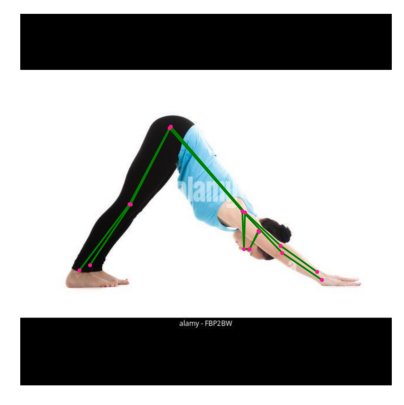

In [135]:
#output_overlay = pose_detection_model(image, prediction)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')